# **Practical Time Series Forecasting with R**
## Chapter 3: Performance Evaluation

In [1]:
## ESTABLISH ENVIRONMENT
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pathlib import Path

def convert_date(date_str):
    # if the string is 'nan' (which can occur if there was a NaN entry in the original data)
    if date_str == 'nan':
        return None
    # try to parse the date assuming it's in the format 'Dec-00'
    try:
        date = datetime.strptime(date_str, '%b-%y')
        if date.year > datetime.now().year:
            date = date.replace(year=date.year-100) # replace century if needed
    except ValueError:
        # if that fails, assume it's in the format '1-Dec'
        try:
            date = datetime.strptime(date_str, '%d-%b')
            # assuming all dates are in 2000s
            date = date.replace(year=2000 + int(date_str.split('-')[0]))
        except ValueError:
            # if both formats fail, return None or handle as you see fit
            return None
    # convert the date into the desired format
    return date.strftime('%B %Y')

# Read Data
Data_Repo = Path("/Users/[Insert Path to Data]/")
Amtrak_data = pd.read_csv(Data_Repo / "Amtrak data.csv", skipfooter=96, skip_blank_lines=True, comment='#', engine='python')

tumblr_data = pd.read_csv(Data_Repo / "Tumblr.csv")
people_ts = tumblr_data['People Worldwide'] / 1000000

# Convert the 'Month' column to string type
Amtrak_data['Month'] = Amtrak_data['Month'].astype(str)

# Apply the date conversion function to the 'Month' column
Amtrak_data['Month'] = Amtrak_data['Month'].apply(convert_date)


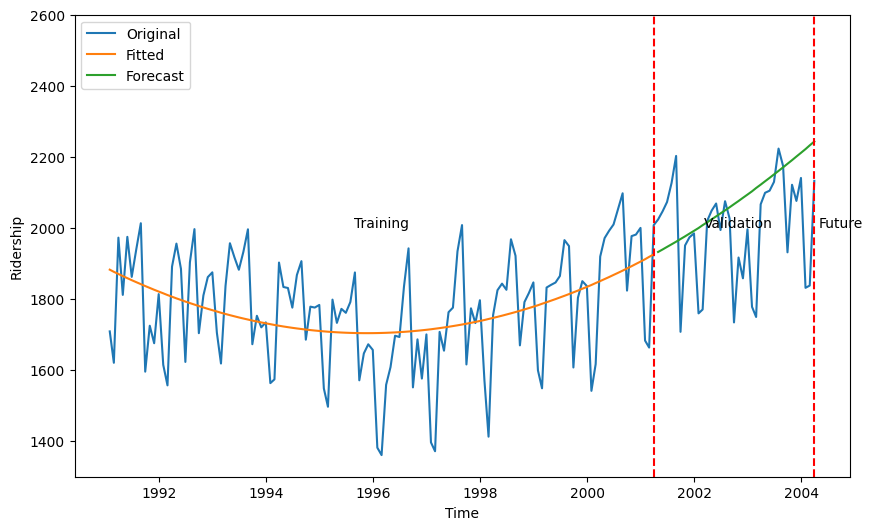

In [2]:
## Figure 3.2: Forecasts in validation period from a quadratic trend model estimated from the training period
# Create Time series
ridership_ts = pd.Series(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'))

# Model Prep
nValid = 36
nTrain = len(ridership_ts) - nValid
train_ts = ridership_ts.iloc[:nTrain]
valid_ts = ridership_ts.iloc[nTrain:nTrain+nValid]

# Model
X = np.array([np.array(range(nTrain)), np.array(range(nTrain))**2]).T
X = sm.add_constant(X)
ridership_lm = sm.OLS(train_ts.values, X).fit()
X_pred = sm.add_constant(np.array([np.array(range(nTrain, nTrain + nValid)), np.array(range(nTrain, nTrain + nValid))**2]).T)
ridership_lm_pred = ridership_lm.predict(X_pred)

# Plot
plt.figure(figsize=(10,6))
plt.plot(ridership_ts.index, ridership_ts.values, label='Original')
plt.plot(train_ts.index, ridership_lm.fittedvalues, label='Fitted')
plt.plot(valid_ts.index, ridership_lm_pred, label='Forecast')
plt.axvline(x=train_ts.index[-1], linestyle='--', color='red')
plt.axvline(x=valid_ts.index[-1], linestyle='--', color='red')
plt.text(train_ts.index[int(len(train_ts)/2)], max(ridership_ts.values)*0.9, 'Training', horizontalalignment='center')
plt.text(valid_ts.index[int(len(valid_ts)/2)], max(ridership_ts.values)*0.9, 'Validation', horizontalalignment='center')
plt.text(valid_ts.index[-1] + pd.DateOffset(months=6), max(ridership_ts.values)*0.9, 'Future', horizontalalignment='center')
plt.ylim([1300, 2600])
plt.ylabel('Ridership')
plt.xlabel('Time')
plt.legend()
plt.show()

In [3]:
## Table 3.1 - Validation of period results of applying a quadratic trend model to Amtrak ridership data
# Residuals
res = np.round(valid_ts - ridership_lm_pred, decimals = 3)

# Display first few rows of prediction, actual values, and residuals
df_result = pd.DataFrame({'Prediction': ridership_lm_pred, 'Actual': valid_ts, 'Residual': res})
print(df_result.head())

# Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

def calculate_metrics(y_true, y_pred):
    ME = np.round( np.mean(y_true - y_pred) , decimals=4 ) # Mean Error - switch act & pred as needed
    RMSE = np.round( np.sqrt(mean_squared_error(y_true, y_pred)), decimals=4 ) # Root Mean Squared Error
    MAE = np.round( mean_absolute_error(y_true, y_pred), decimals=4 ) # Mean Absolute Error
    MPE = np.round( np.mean((y_true - y_pred) / y_true) * 100, decimals=4 ) # Mean Percentage Error - switch act & pred as needed
    MAPE = np.round( np.mean(np.abs((y_pred - y_true) / y_true)) * 100, decimals=4 ) # Mean Absolute Percentage Error
    residuals = y_true - y_pred
    ACF1 = np.round( pearsonr(residuals[:-1], residuals[1:])[0], decimals=4) # Autocorrelation of residuals at lag 1
    SD_actual = np.std(y_true, ddof=1) # ddof=1 to use the unbiased estimator (n-1 in the denominator)
    SD_residuals = np.std(residuals, ddof=1)
    Theil_U = np.round( np.sqrt((np.sum(np.square(y_pred - y_true)) / nValid) / (SD_actual * SD_residuals)), decimals=4 )# Theil's U statistic
    return ME, RMSE, MAE, MPE, MAPE, ACF1, Theil_U

# Calculate metrics
ME, RMSE, MAE, MPE, MAPE, ACF1, Theil_U = calculate_metrics(valid_ts.values, ridership_lm_pred)
print(f"ME: {ME}, RMSE: {RMSE}, MAE: {MAE}, MPE: {MPE}, MAPE: {MAPE}, ACF1: {ACF1}, Theil's U: {Theil_U}")


             Prediction    Actual  Residual
2001-04-30  1932.454168  2023.792    91.338
2001-05-31  1939.508338  2047.008   107.500
2001-06-30  1946.669753  2072.913   126.243
2001-07-31  1953.938413  2126.717   172.779
2001-08-31  1961.314317  2202.638   241.324
ME: -83.9621, RMSE: 179.8494, MAE: 133.7383, MPE: -4.7254, MAPE: 7.0757, ACF1: 0.4248, Theil's U: 1.18


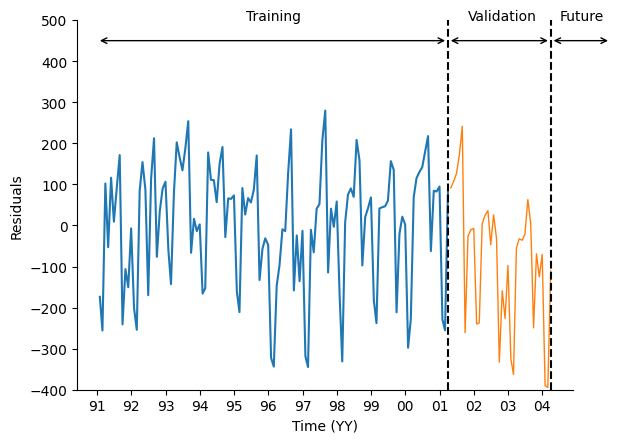

In [4]:
# Calculating & Viewing Residuals
residuals_train = ridership_lm.resid  # Training Residuals
residuals_valid = valid_ts - ridership_lm_pred  # Validation Residuals

# Convert residuals to pandas Series for plotting
residuals_train_series = pd.Series(residuals_train, index=train_ts.index)
residuals_valid_series = pd.Series(residuals_valid.values, index=valid_ts.index)

# Plotting Residuals
fig, ax = plt.subplots()
ax.plot(residuals_train_series, label="Training Residuals")
ax.plot(residuals_valid_series, label="Validation Residuals", linewidth=1)
ax.set_ylim(-400, 500)
ax.set_xlabel('Time (YY)')
ax.set_ylabel('Residuals')

# Setting x-axis labels
years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%y')  # Changed from '%Y' to '%y'
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Adding vertical lines
ax.axvline(train_ts.index[-1], color='black', linestyle='dashed')
ax.axvline(valid_ts.index[-1], color='black', linestyle='dashed')

# Adding text labels
ax.text(train_ts.index[int(len(train_ts)/2)], 500, 'Training', horizontalalignment='center')
ax.text(valid_ts.index[int(len(valid_ts)/2)], 500, 'Validation', horizontalalignment='center')
ax.text(valid_ts.index[-1] + pd.DateOffset(months=11), 500 , 'Future', horizontalalignment='center')

# Adding arrows
ax.annotate("", xy=(pd.to_datetime('1991-01-01'), 450), xytext=(train_ts.index[-1], 450), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(train_ts.index[-1], 450), xytext=(valid_ts.index[-1], 450), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(valid_ts.index[-1], 450), xytext=(pd.to_datetime('2006-01-01'), 450), arrowprops=dict(arrowstyle="<->"))

# Update Plot & Show
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

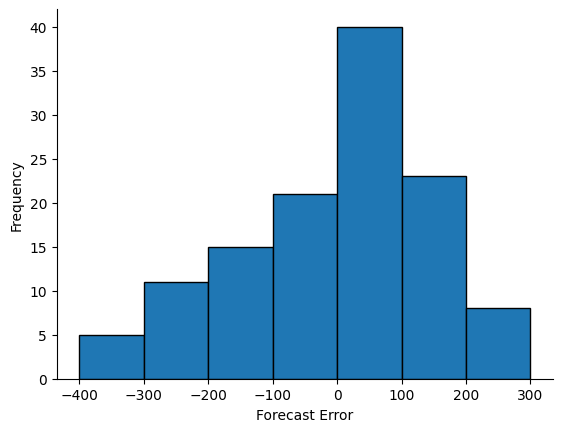

In [5]:
## Figure 3-4: Histogram of forecast erros in the training period from a quadratic trend model
fig, ax = plt.subplots()
range_min = int(min(residuals_train) // 100 * 100)  # get the floor of the minimum value
range_max = int(max(residuals_train) // 100 * 100 + 200)  # get the ceil of the maximum value
bins = range(range_min, range_max, 100)  # create bins of size 100
ax.hist(residuals_train, bins=bins, edgecolor='black')  # use the bins in the histogram
ax.set_xlabel("Forecast Error")
ax.set_ylabel("Frequency")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# ## Figure 3-4: Dynamic Sqrt Bin Method
# fig, ax = plt.subplots()
# bins = int(np.sqrt(len(residuals_train)))
# ax.hist(residuals_train, bins=bins, edgecolor='black')  # use the bins in the histogram
# ax.set_xlabel("Forecast Error")
# ax.set_ylabel("Frequency")
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.show()


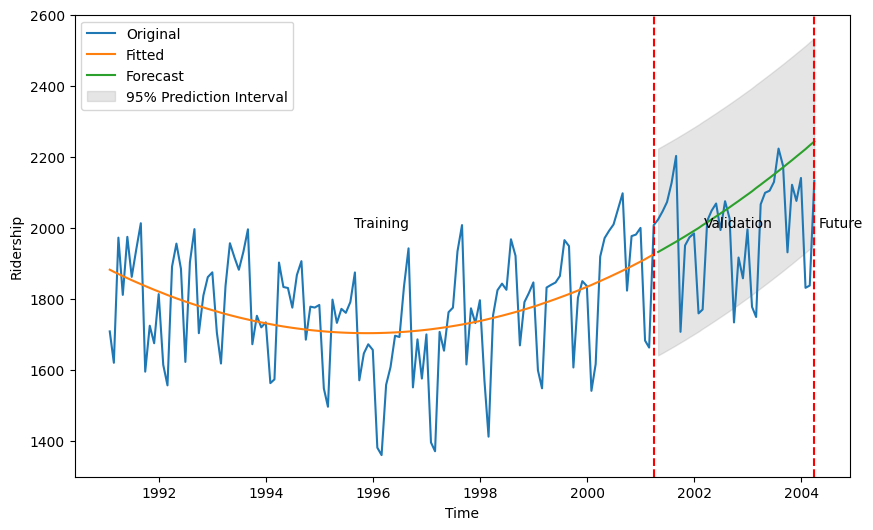

In [6]:
## Figure 3.5: Point forecasts and 95% prediction intervals in validation period from quadratic trend model
from scipy.stats import t

# Model
X = np.array([np.array(range(nTrain)), np.array(range(nTrain))**2]).T
X = sm.add_constant(X)
ridership_lm = sm.OLS(train_ts.values, X).fit()
X_pred = sm.add_constant(np.array([np.array(range(nTrain, nTrain + nValid)), np.array(range(nTrain, nTrain + nValid))**2]).T)
ridership_lm_pred = ridership_lm.predict(X_pred)

# Get standard error of the residuals
std_err = np.std(ridership_lm.resid)

# Get critical value from t-distribution for 95% confidence interval
crit_value = t.ppf(1 - 0.05 / 2, df=nTrain - 3)  # df = number of observations - number of parameters

# Calculate prediction intervals
lower = ridership_lm_pred - crit_value * std_err
upper = ridership_lm_pred + crit_value * std_err

# Plot
plt.figure(figsize=(10,6))
plt.plot(ridership_ts.index, ridership_ts.values, label='Original')
plt.plot(train_ts.index, ridership_lm.fittedvalues, label='Fitted')
plt.plot(valid_ts.index, ridership_lm_pred, label='Forecast')
plt.fill_between(valid_ts.index, lower, upper, color='gray', alpha=0.2, label='95% Prediction Interval')
plt.axvline(x=train_ts.index[-1], linestyle='--', color='red')
plt.axvline(x=valid_ts.index[-1], linestyle='--', color='red')
plt.text(train_ts.index[int(len(train_ts)/2)], max(ridership_ts.values)*0.9, 'Training', horizontalalignment='center')
plt.text(valid_ts.index[int(len(valid_ts)/2)], max(ridership_ts.values)*0.9, 'Validation', horizontalalignment='center')
plt.text(valid_ts.index[-1] + pd.DateOffset(months=6), max(ridership_ts.values)*0.9, 'Future', horizontalalignment='center')
plt.ylim([1300, 2600])
plt.ylabel('Ridership')
plt.xlabel('Time')
plt.legend()
plt.show()


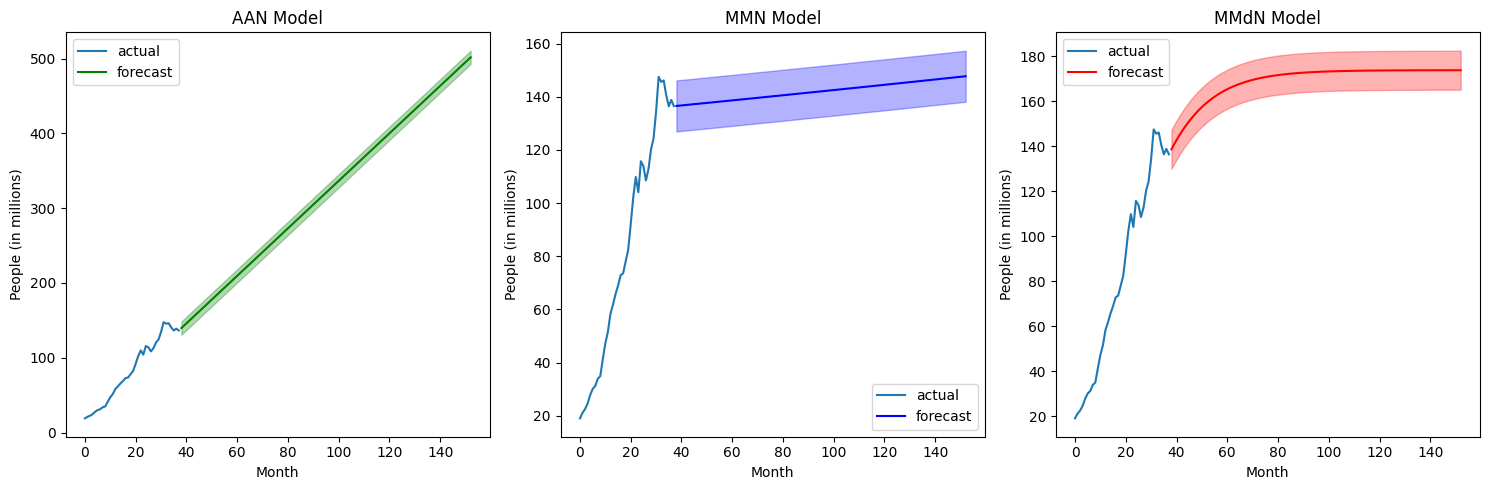

Lower limits of MMN model's prediction cone:
38     126.969691
39     127.063913
40     127.158200
41     127.252552
42     127.346969
          ...    
148    137.733662
149    137.835311
150    137.937029
151    138.038817
152    138.140676
Length: 115, dtype: float64
Upper limits of MMN model's prediction cone:
38     146.174431
39     146.268653
40     146.362940
41     146.457292
42     146.551709
          ...    
148    156.938403
149    157.040051
150    157.141769
151    157.243557
152    157.345416
Length: 115, dtype: float64


In [7]:
## Figure 3.6 - Prediction Cones from three exponential smoothing models fit to the Tumblr Data

import numpy as np
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Run three exponential smoothing models: AAN, MMN, and MMdN.
model_AAN = ExponentialSmoothing(people_ts, trend='add', seasonal=None).fit()
model_MMN = ExponentialSmoothing(people_ts, trend='mul', seasonal=None, damped_trend=False).fit()
model_MMdN = ExponentialSmoothing(people_ts, trend='mul', seasonal=None, damped_trend=True).fit()

# Create their prediction "cones" for 115 months into the future (Jun 2013 to Dec 2022).
pred_AAN = model_AAN.forecast(115)
pred_MMN = model_MMN.forecast(115)
pred_MMdN = model_MMdN.forecast(115)

# Calculate the standard deviation of the residuals
residual_std_AAN = np.std(model_AAN.resid)
residual_std_MMN = np.std(model_MMN.resid)
residual_std_MMdN = np.std(model_MMdN.resid)

# Calculate the prediction intervals
def get_prediction_interval(prediction, residual_std, alpha=0.05):
    # Calculate the z value (z score) using the standard normal distribution
    z = stats.norm.ppf(1 - alpha / 2)

    # Calculate the prediction intervals
    interval_lower = prediction - (z * residual_std)
    interval_upper = prediction + (z * residual_std)

    return interval_lower, interval_upper

ci_AAN_lower, ci_AAN_upper = get_prediction_interval(pred_AAN, residual_std_AAN)
ci_MMN_lower, ci_MMN_upper = get_prediction_interval(pred_MMN, residual_std_MMN)
ci_MMdN_lower, ci_MMdN_upper = get_prediction_interval(pred_MMdN, residual_std_MMdN)

###################################
## VISUALIZATION & OUTPUT
###################################
import matplotlib.pyplot as plt
import numpy as np

# Creating a sequence of integers for the forecast period
forecast_periods = np.arange(len(people_ts), len(people_ts) + 115)

# Creating plots
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot for AAN model
axes[0].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[0].plot(forecast_periods, pred_AAN, color='green', label='forecast')
axes[0].fill_between(forecast_periods, ci_AAN_lower, ci_AAN_upper, color='green', alpha=0.3)
axes[0].set_title('AAN Model')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('People (in millions)')
axes[0].legend()

# Plot for MMN model
axes[1].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[1].plot(forecast_periods, pred_MMN, color='blue', label='forecast')
axes[1].fill_between(forecast_periods, ci_MMN_lower, ci_MMN_upper, color='blue', alpha=0.3)
axes[1].set_title('MMN Model')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('People (in millions)')
axes[1].legend()

# Plot for MMdN model
axes[2].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[2].plot(forecast_periods, pred_MMdN, color='red', label='forecast')
axes[2].fill_between(forecast_periods, ci_MMdN_lower, ci_MMdN_upper, color='red', alpha=0.3)
axes[2].set_title('MMdN Model')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('People (in millions)')
axes[2].legend()

# Showing the plots
plt.tight_layout()
plt.show()

# Examine the lower and upper limits of the MMN model's prediction cones.
print("Lower limits of MMN model's prediction cone:")
print(ci_MMN_lower)

print("Upper limits of MMN model's prediction cone:")
print(ci_MMN_upper)


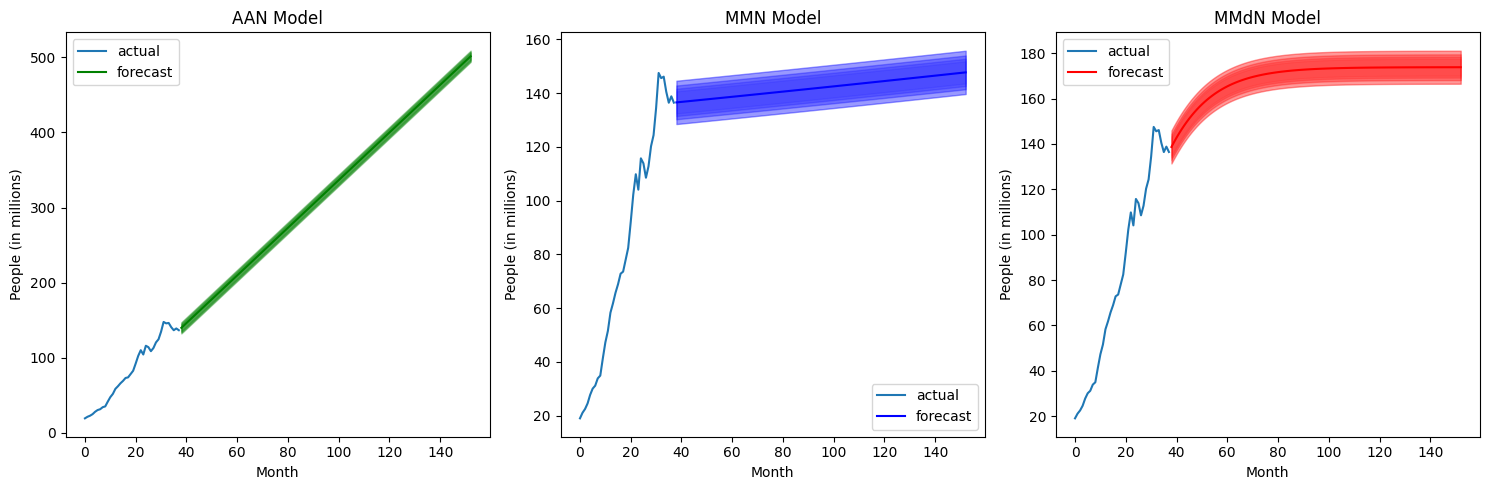

Lower limits of MMN model's prediction cone:
38     132.448741
39     132.542963
40     132.637250
41     132.731602
42     132.826019
          ...    
148    143.212713
149    143.314361
150    143.416079
151    143.517867
152    143.619726
Length: 115, dtype: float64
Upper limits of MMN model's prediction cone:
38     140.695381
39     140.789603
40     140.883890
41     140.978242
42     141.072659
          ...    
148    151.459353
149    151.561001
150    151.662719
151    151.764507
152    151.866366
Length: 115, dtype: float64


In [8]:
## Figure 3.6 (OPTION 2 - Multiple Confidence Intervals) - Prediction Cones from three exponential smoothing models fit to the Tumblr Data
import numpy as np
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Run three exponential smoothing models: AAN, MMN, and MMdN.
model_AAN = ExponentialSmoothing(people_ts, trend='add', seasonal=None).fit()
model_MMN = ExponentialSmoothing(people_ts, trend='mul', seasonal=None, damped_trend=False).fit()
model_MMdN = ExponentialSmoothing(people_ts, trend='mul', seasonal=None, damped_trend=True).fit()

# Create their prediction "cones" for 115 months into the future (Jun 2013 to Dec 2022).
pred_AAN = model_AAN.forecast(115)
pred_MMN = model_MMN.forecast(115)
pred_MMdN = model_MMdN.forecast(115)

# Calculate the standard deviation of the residuals
residual_std_AAN = np.std(model_AAN.resid)
residual_std_MMN = np.std(model_MMN.resid)
residual_std_MMdN = np.std(model_MMdN.resid)

# Calculate the prediction intervals
def get_prediction_interval(prediction, residual_std, alpha):
    # Calculate the z value (z score) using the standard normal distribution
    z = stats.norm.ppf(1 - alpha / 2)

    # Calculate the prediction intervals
    interval_lower = prediction - (z * residual_std)
    interval_upper = prediction + (z * residual_std)

    return interval_lower, interval_upper

# Generate prediction intervals at 60%, 70%, 80%, 90% confidence levels
ci_AAN_60_lower, ci_AAN_60_upper = get_prediction_interval(pred_AAN, residual_std_AAN, alpha=0.4)
ci_AAN_70_lower, ci_AAN_70_upper = get_prediction_interval(pred_AAN, residual_std_AAN, alpha=0.3)
ci_AAN_80_lower, ci_AAN_80_upper = get_prediction_interval(pred_AAN, residual_std_AAN, alpha=0.2)
ci_AAN_90_lower, ci_AAN_90_upper = get_prediction_interval(pred_AAN, residual_std_AAN, alpha=0.1)

ci_MMN_60_lower, ci_MMN_60_upper = get_prediction_interval(pred_MMN, residual_std_MMN, alpha=0.4)
ci_MMN_70_lower, ci_MMN_70_upper = get_prediction_interval(pred_MMN, residual_std_MMN, alpha=0.3)
ci_MMN_80_lower, ci_MMN_80_upper = get_prediction_interval(pred_MMN, residual_std_MMN, alpha=0.2)
ci_MMN_90_lower, ci_MMN_90_upper = get_prediction_interval(pred_MMN, residual_std_MMN, alpha=0.1)

ci_MMdN_60_lower, ci_MMdN_60_upper = get_prediction_interval(pred_MMdN, residual_std_MMdN, alpha=0.4)
ci_MMdN_70_lower, ci_MMdN_70_upper = get_prediction_interval(pred_MMdN, residual_std_MMdN, alpha=0.3)
ci_MMdN_80_lower, ci_MMdN_80_upper = get_prediction_interval(pred_MMdN, residual_std_MMdN, alpha=0.2)
ci_MMdN_90_lower, ci_MMdN_90_upper = get_prediction_interval(pred_MMdN, residual_std_MMdN, alpha=0.1)


###################################
## VISUALIZATION & OUTPUT
###################################
import matplotlib.pyplot as plt

# Creating a sequence of integers for the forecast period
forecast_periods = np.arange(len(people_ts), len(people_ts) + 115)

# Creating plots
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot for AAN model
axes[0].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[0].plot(forecast_periods, pred_AAN, color='green', label='forecast')
axes[0].fill_between(forecast_periods, ci_AAN_60_lower, ci_AAN_60_upper, color='green', alpha=0.1)
axes[0].fill_between(forecast_periods, ci_AAN_70_lower, ci_AAN_70_upper, color='green', alpha=0.2)
axes[0].fill_between(forecast_periods, ci_AAN_80_lower, ci_AAN_80_upper, color='green', alpha=0.3)
axes[0].fill_between(forecast_periods, ci_AAN_90_lower, ci_AAN_90_upper, color='green', alpha=0.4)
axes[0].set_title('AAN Model')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('People (in millions)')
axes[0].legend()

# Repeat for MMN and MMdN models...
axes[1].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[1].plot(forecast_periods, pred_MMN, color='blue', label='forecast')
axes[1].fill_between(forecast_periods, ci_MMN_60_lower, ci_MMN_60_upper, color='blue', alpha=0.1)
axes[1].fill_between(forecast_periods, ci_MMN_70_lower, ci_MMN_70_upper, color='blue', alpha=0.2)
axes[1].fill_between(forecast_periods, ci_MMN_80_lower, ci_MMN_80_upper, color='blue', alpha=0.3)
axes[1].fill_between(forecast_periods, ci_MMN_90_lower, ci_MMN_90_upper, color='blue', alpha=0.4)
axes[1].set_title('MMN Model')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('People (in millions)')
axes[1].legend()

axes[2].plot(np.arange(len(people_ts)), people_ts.values, label='actual')
axes[2].plot(forecast_periods, pred_MMdN, color='red', label='forecast')
axes[2].fill_between(forecast_periods, ci_MMdN_60_lower, ci_MMdN_60_upper, color='red', alpha=0.1)
axes[2].fill_between(forecast_periods, ci_MMdN_70_lower, ci_MMdN_70_upper, color='red', alpha=0.2)
axes[2].fill_between(forecast_periods, ci_MMdN_80_lower, ci_MMdN_80_upper, color='red', alpha=0.3)
axes[2].fill_between(forecast_periods, ci_MMdN_90_lower, ci_MMdN_90_upper, color='red', alpha=0.4)
axes[2].set_title('MMdN Model')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('People (in millions)')
axes[2].legend()


# Showing the plots
plt.tight_layout()
plt.show()

# Examine the lower and upper limits of the MMN model's prediction cones.
print("Lower limits of MMN model's prediction cone:")
print(ci_MMN_60_lower)

print("Upper limits of MMN model's prediction cone:")
print(ci_MMN_60_upper)


In [9]:
## Table 3.3: Performance of Naive Forecasts using fixed vs. Roll-forward partitoning
fixed_n_valid = 36
fixed_n_train = len(ridership_ts) - fixed_n_valid
steps_ahead = 1
error = np.zeros(fixed_n_valid - steps_ahead + 1)
percent_error = np.zeros(fixed_n_valid - steps_ahead + 1)

for j in range(fixed_n_train, fixed_n_train + fixed_n_valid - steps_ahead):
    train_ts = ridership_ts.iloc[:j+1]  # adjusting indexing to be inclusive
    valid_ts = ridership_ts.iloc[j + steps_ahead:j + steps_ahead + 2]  # adjusting indexing to be inclusive
    
    naive_pred = train_ts.iloc[-1]  # Naive forecast: the prediction is the last observed value
    
    error[j - fixed_n_train] = valid_ts.values[0] - naive_pred
    percent_error[j - fixed_n_train] = error[j - fixed_n_train] / valid_ts.values[0]

mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(np.power(error, 2)))
mape = np.mean(np.abs(percent_error))

print("MAE: ", mae)
print("RMSE: ", rmse)
print("MAPE: ", mape)


MAE:  118.98822222222222
RMSE:  169.15260333333458
MAPE:  0.061842917913175394


In [13]:
## Table 3.4 & 3.5 (Performance of Naive vs. Seasonal Naive Forecasts Using Fixed Partitioning)
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

fixed_n_valid = 36
fixed_n_train = len(ridership_ts) - fixed_n_valid

train_ts = ridership_ts.iloc[:fixed_n_train]
valid_ts = ridership_ts.iloc[fixed_n_train:(fixed_n_train + fixed_n_valid)]

# Fit a simple exponential smoothing model
model_naive = SimpleExpSmoothing(train_ts).fit(smoothing_level=1)
naive_pred = model_naive.forecast(steps=fixed_n_valid)

# For SNAIVE model, we take the data point from the same period in the last season
seasonality = 12 ## In R, ridership.ts has freq = 12
snaive_pred = train_ts.iloc[-seasonality:]  # take the last year of the training set
snaive_pred = pd.concat([snaive_pred] * (fixed_n_valid // seasonality))  # repeat for the number of years in the validation set
snaive_pred = snaive_pred.reset_index(drop=True)
snaive_pred.index = valid_ts.index  # reset the index to match the validation set

# Calculate the accuracy metrics
mae_naive = mean_absolute_error(valid_ts, naive_pred)
rmse_naive = np.sqrt(mean_squared_error(valid_ts, naive_pred))
mape_naive = mean_absolute_percentage_error(valid_ts, naive_pred)

mae_snaive = mean_absolute_error(valid_ts, snaive_pred)
rmse_snaive = np.sqrt(mean_squared_error(valid_ts, snaive_pred))
mape_snaive = mean_absolute_percentage_error(valid_ts, snaive_pred)

print(f"Naive model accuracy - MAE: {mae_naive}, RMSE: {rmse_naive}, MAPE: {mape_naive}%")
print(f"Snaive model accuracy - MAE: {mae_snaive}, RMSE: {rmse_snaive}, MAPE: {mape_snaive}%")


Naive model accuracy - MAE: 115.92338888888887, RMSE: 142.75509467791335, MAPE: 6.021395581017416%
Snaive model accuracy - MAE: 84.09405555555557, RMSE: 95.62433273405537, MAPE: 4.247656424125468%


In [14]:
##Table 3.6: Performance of Naive vs. Seasonal Naive one-step-ahead forecast using roll-forward partitioning
fixed_n_valid = 36
fixed_n_train = len(ridership_ts) - fixed_n_valid
seasonality = 12
error_naive = np.zeros(fixed_n_valid)
percent_error_naive = np.zeros(fixed_n_valid)
error_snaive = np.zeros(fixed_n_valid)
percent_error_snaive = np.zeros(fixed_n_valid)

for i in range(fixed_n_valid):
    train_ts = ridership_ts.iloc[:fixed_n_train+i]  
    valid_ts = ridership_ts.iloc[fixed_n_train+i:fixed_n_train+i+1]  

    # Naive forecast: the prediction is the last observed value
    naive_pred = train_ts.iloc[-1]  
    
    # Seasonal naive forecast: the prediction is the value from the same month in the previous year
    snaive_pred = train_ts.iloc[-seasonality] 

    error_naive[i] = valid_ts.values[0] - naive_pred
    percent_error_naive[i] = error_naive[i] / valid_ts.values[0]

    error_snaive[i] = valid_ts.values[0] - snaive_pred
    percent_error_snaive[i] = error_snaive[i] / valid_ts.values[0]

mae_naive = np.mean(np.abs(error_naive))
rmse_naive = np.sqrt(np.mean(np.power(error_naive, 2)))
mape_naive = np.mean(np.abs(percent_error_naive))

mae_snaive = np.mean(np.abs(error_snaive))
rmse_snaive = np.sqrt(np.mean(np.power(error_snaive, 2)))
mape_snaive = np.mean(np.abs(percent_error_snaive))

print("NAIVE:")
print("MAE: ", mae_naive)
print("RMSE: ", rmse_naive)
print("MAPE: ", mape_naive)

print("\nSNAIVE:")
print("MAE: ", mae_snaive)
print("RMSE: ", rmse_snaive)
print("MAPE: ", mape_snaive)


NAIVE:
MAE:  119.42888888888888
RMSE:  169.17326606306457
MAPE:  0.062060660975044736

SNAIVE:
MAE:  78.47275000000002
RMSE:  98.204553273738
MAPE:  0.03905670701344525
